Annotating and reading the Walsh lab data that was uniformly processed by Taejeon Bae using the bsmn-pipeline.  The number of calls per sample is unexpectedly high in this data set: much higher than reported by Rodin et al (see https://www.biorxiv.org/content/10.1101/2020.02.11.944413v1), who used MosaicForecast instead of the bsmn-pipeline.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import attila_utils
from bsmcalls import readVCF, individuals, preprocessing
import attila_utils
%matplotlib inline

In [2]:
data = individuals.get_datasets(merge=True)
data['tissue'] = data.index.get_level_values('Tissue')
data['individual ID'] = data.index.get_level_values('Individual ID')
def get_dataset(dataset='Chess'):
    dset = data.copy().loc[data['Dataset'] == dataset, :]
    dset['Dx'] = dset['Dx'].cat.remove_unused_categories()
    return(dset)

chess = get_dataset('Chess')
walsh = get_dataset('Walsh')

Filter for `HC` (see `FILTER` field)

In [3]:
HC_list = ['HC/PASS', 'HC;PASS/PASS']
walsh = walsh.loc[walsh['FILTER/PASS'].isin(HC_list)]

In [4]:
def get_margins(df):
    df = df.copy()
    df = pd.concat([df, df.sum(axis=1)], axis=1)
    df = pd.concat([df, pd.DataFrame(df.sum(axis=0)).T], axis=0)
    df = df.rename({0: 'Sum'}, axis=0).rename({0: 'Sum'}, axis=1)
    return(df)

In [5]:
def concat_counts(c, w):
    c = c.rename({'SCZ': 'Case'}, axis=1).loc[['NeuN_pl']].rename({'NeuN_pl': 'Chess'}, axis=0)
    w = w.rename({'ASD': 'Case'}, axis=1).rename({'frontal cortex': 'Walsh'}, axis=0)
    counts = pd.concat([c, w])
    return(counts)

### Total number of calls

['named-figure/ncalls-chess-walsh-barplot.png',
 'named-figure/ncalls-chess-walsh-barplot.pdf']

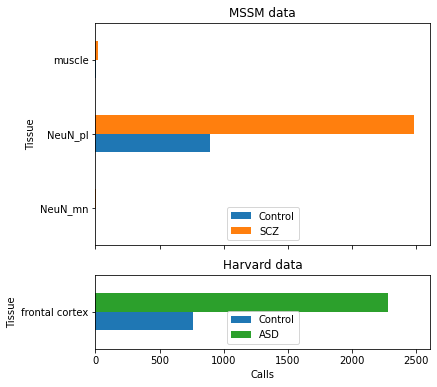

In [20]:
c = chess.groupby(['Tissue', 'Dx']).size()
w = walsh.groupby(['Tissue', 'Dx']).size()
# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6), gridspec_kw=dict(height_ratios=[3, 1]))
c.unstack().plot(kind='barh', ax=ax[0], legend=False)
w.unstack().loc[:, ['Control', 'ASD']].plot(kind='barh', ax=ax[1], color=['C0', 'C2'])
ax[0].set_title('MSSM data')
ax[1].set_title('Harvard data')
ax[1].set_xlabel('Calls')
ax[0].legend(loc='lower center')
ax[1].legend(loc='lower center')
attila_utils.savefig(fig, 'ncalls-chess-walsh-barplot')

In [7]:
c.unstack()

Dx,Control,SCZ
Tissue,,
NeuN_mn,0,1
NeuN_pl,895,2488
muscle,6,21


In [8]:
w.unstack()

Dx,Control,ASD
Tissue,,
frontal cortex,758,2285


Put results together: use only NeuN_pl calls from the Chess data set

In [9]:
get_margins(concat_counts(c.unstack(), w.unstack()))

,Control,Case,Sum
Chess,895,2488,3383
Walsh,758,2285,3043
Sum,1653,4773,6426


### Number of samples

['named-figure/nsamples-chess-walsh-barplot.png',
 'named-figure/nsamples-chess-walsh-barplot.pdf']

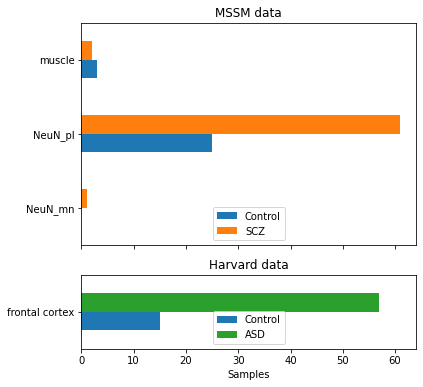

In [19]:
def get_nsamples(df):
    d = {name: len(group.index.get_level_values('Individual ID').unique()) for name, group in df.groupby(['Tissue', 'Dx'])}
    val = pd.Series(d).unstack().fillna(0).astype('int64')
    return(val)

def get_nsamples2(df):
    '''This implementation uses pivot tables'''
    df = df.copy()
    df['Ind ID'] = df.index.get_level_values('Individual ID')
    val = df.pivot_table(values='Ind ID', columns='Dx', index='Tissue', aggfunc='nunique')
    #val = df.pivot_table(values='Ind ID', columns='Dx', index='Tissue', aggfunc=lambda x: len(pd.unique(x)))
    val = val.fillna(0).astype('int64')
    return(val)
                         

# plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6), gridspec_kw=dict(height_ratios=[3, 1]))
get_nsamples(chess).plot(kind='barh', legend=False, ax=ax[0])
get_nsamples(walsh).loc[:, ['Control', 'ASD']].plot(kind='barh', legend=False, ax=ax[1], color=['C0', 'C2'])
ax[0].set_title('MSSM data')
ax[1].set_title('Harvard data')
ax[1].set_xlabel('Samples')
ax[0].legend(loc='lower center')
ax[1].legend(loc='lower center')
attila_utils.savefig(fig, 'nsamples-chess-walsh-barplot')

In [11]:
get_margins(concat_counts(c=get_nsamples(chess), w=get_nsamples(walsh)))

,Control,Case,Sum
Chess,25,61,86
Walsh,15,57,72
Sum,40,118,158


### Calls per sample

In [12]:
def indiv_stats(calls, tissue, Dx):
    counts = calls.groupby(['Tissue', 'Dx'])['individual ID'].value_counts()
    counts = counts.xs((tissue, Dx), level=('Tissue', 'Dx'))
    meanDP = calls.loc[calls['individual ID'].isin(counts.index)].groupby('Individual ID')['DP'].mean()
    df = pd.concat([counts, meanDP], axis=1).rename({'individual ID': 'n calls', 'DP': 'read depth'}, axis=1)
    return(df)

ccon = indiv_stats(chess, 'NeuN_pl', 'Control')
caff = indiv_stats(chess, 'NeuN_pl', 'SCZ')
wcon = indiv_stats(walsh, 'frontal cortex', 'Control')
waff = indiv_stats(walsh, 'frontal cortex', 'ASD')

Text(0.5, 0, '# calls per sample')

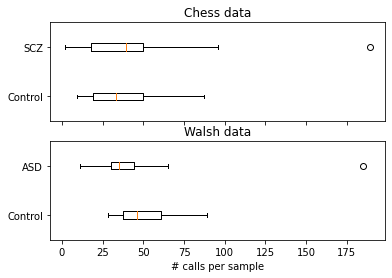

In [13]:
%matplotlib inline
# plot figure
fig, ax = plt.subplots(2,1, sharex=True)
lines = ax[0].boxplot([ccon['n calls'], caff['n calls']], vert=False, labels=['Control', 'SCZ'])
ax[0].set_title('Chess data')
lines = ax[1].boxplot([wcon['n calls'], waff['n calls']], vert=False, labels=['Control', 'ASD'])
ax[1].set_title('Walsh data')
ax[1].set_xlabel('# calls per sample')


['named-figure/ncalls-chess-walsh-hist.png',
 'named-figure/ncalls-chess-walsh-hist.pdf']

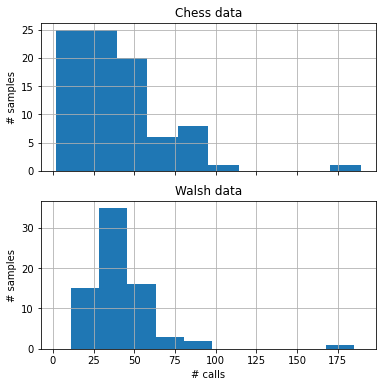

In [14]:
bins = np.arange(0, 304, 8)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
pd.concat([ccon['n calls'], caff['n calls']], axis=0).hist(ax=ax[0])
pd.concat([wcon['n calls'], waff['n calls']], axis=0).hist(ax=ax[1])
ax[0].set_title('Chess data')
ax[1].set_title('Walsh data')
ax[1].set_title('Walsh data')
ax[0].set_ylabel('# samples')
ax[1].set_ylabel('# samples')
ax[1].set_xlabel('# calls')
attila_utils.savefig(fig, 'ncalls-chess-walsh-hist')

['named-figure/ncalls-depth-chess-walsh.png',
 'named-figure/ncalls-depth-chess-walsh.pdf']

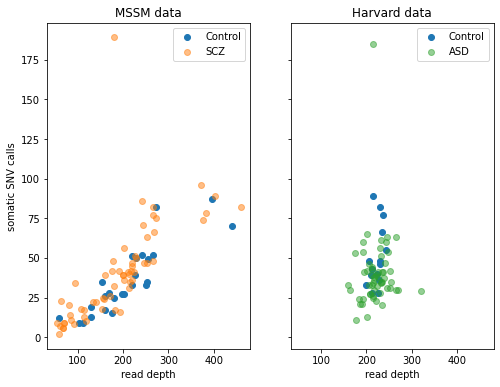

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True)
ax[0].scatter(x='read depth', y='n calls', c='C0', data=ccon, label='Control')
ax[0].scatter(x='read depth', y='n calls', c='C1', alpha=0.5, data=caff, label='SCZ')
ax[0].set_title('MSSM data')
ax[0].set_xlabel('read depth')
ax[0].set_ylabel('somatic SNV calls')
ax[0].legend()
ax[1].scatter(x='read depth', y='n calls', c='C0', data=wcon, label='Control')
ax[1].scatter(x='read depth', y='n calls', c='C2', alpha=0.5, data=waff, label='ASD')
ax[1].set_title('Harvard data')
ax[1].set_xlabel('read depth')
ax[1].legend()
attila_utils.savefig(fig, 'ncalls-depth-chess-walsh')

In [16]:
%connect_info

{
  "shell_port": 38233,
  "iopub_port": 59637,
  "stdin_port": 56359,
  "control_port": 44347,
  "hb_port": 37909,
  "ip": "127.0.0.1",
  "key": "54ccbd1c-ba732fc69abec9b9122afe0c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-ec16b13f-088a-4f84-85eb-6c57873741d2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
